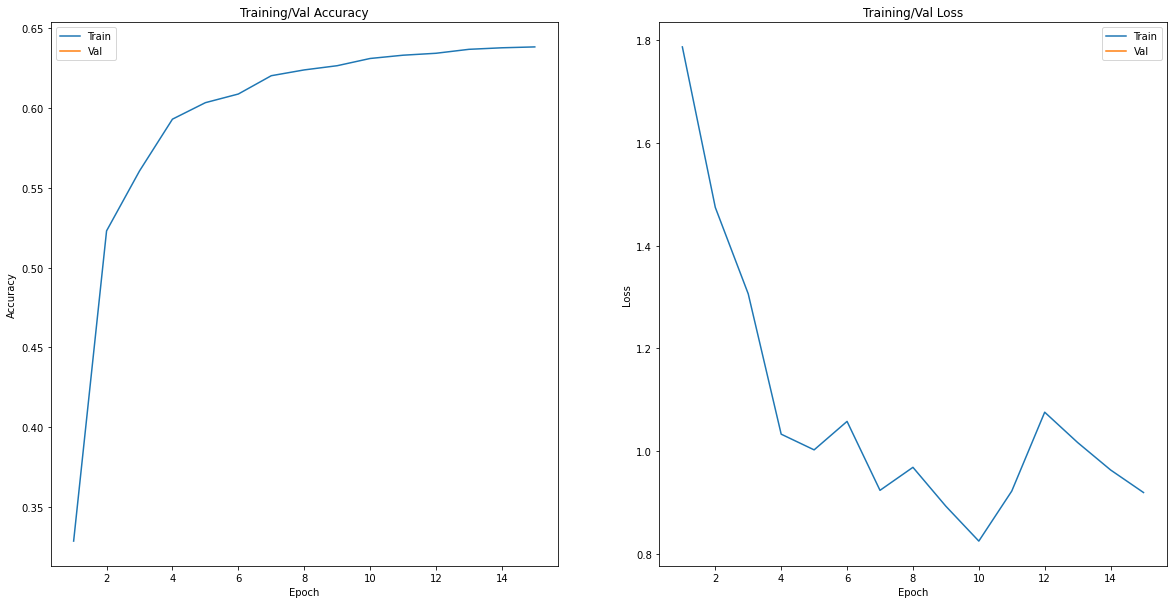

LR : 0.001, Batch Size : 128, 현재 Epoch : 15
Train 정확도 : 0.6383479237556458, Train Loss : 0.9199042320251465


IndexError: list index out of range

In [18]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
from dataset import Dacon
from model import *
from PIL import Image
from tqdm.auto import tqdm, trange
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets

checkpoint = torch.load('b1_0.001.pt')
train_accuracy_list = checkpoint['train_accuracy']
train_loss_list = checkpoint['train_loss']
val_accuracy_list = checkpoint['val_accuracy']
val_loss_list = checkpoint['val_loss']
learning_rate = checkpoint['learning_rate']
batch_size = checkpoint['batch_size']

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].set_title("Training/Val Accuracy")
ax[0].set_ylabel("Accuracy")
ax[0].set_xlabel("Epoch")
ax[0].plot(range(1, len(train_accuracy_list)+1), train_accuracy_list)
ax[0].plot(range(1, len(val_accuracy_list)+1), val_accuracy_list)
ax[0].legend(['Train', 'Val'])
#ax[0].set_xlim(left=15)
#ax[0].set_ylim(bottom=0.8)

ax[1].set_title("Training/Val Loss")
ax[1].set_ylabel("Loss")
ax[1].set_xlabel("Epoch")
ax[1].plot(range(1, len(train_loss_list)+1), train_loss_list)
ax[1].plot(range(1, len(val_loss_list)+1), val_loss_list)
ax[1].legend(['Train', 'Val'])
#ax[1].set_xlim(left=15)
#ax[1].set_ylim(top=1.5)
plt.show()

print(f"LR : {learning_rate}, Batch Size : {batch_size}, 현재 Epoch : {checkpoint['epoch']}")
print(f"Train 정확도 : {train_accuracy_list[-1]}, Train Loss : {train_loss_list[-1]}")
print(f"Val 정확도 : {val_accuracy_list[-1]}, Val Loss : {val_loss_list[-1]}")
print(f"가장 높은 Val 정확도 : {max(val_accuracy_list)}")

In [6]:
import torch
import timm

model = timm.create_model('vit_large_patch16_224', pretrained=True, num_classes=1049)
model.cuda()
img = torch.randn(32, 3, 224, 224).cuda()
model(img)



tensor([[-0.3793, -0.0820, -0.0544,  ..., -0.5081,  0.0711,  0.6247],
        [-0.2161, -0.0503,  0.2946,  ..., -0.4675,  0.0097,  0.7499],
        [-0.5403, -0.1900, -0.1417,  ..., -0.6823,  0.1711,  0.5703],
        ...,
        [-0.3692, -0.1865,  0.2712,  ..., -0.3388,  0.1270,  0.7388],
        [-0.4171, -0.1174, -0.0190,  ..., -0.3531,  0.1208,  0.4878],
        [-0.3602, -0.2035,  0.0083,  ..., -0.6465,  0.1509,  0.8887]],
       device='cuda:0', grad_fn=<AddmmBackward>)